In [1]:
# set working directory
import sys
import os
from pathlib import Path
sys.path.insert(0, Path(os.getcwd()).parent)
os.chdir(sys.path[0])

# Unsupervised ML from Seismic Attributes

In [78]:
# Import libraries
from cuml.manifold import UMAP
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os
import rasterio
from rasterio.plot import show
import geopandas as gpd
from shapely.geometry import Point
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from sknetwork.clustering import Louvain

In [3]:
# Import functions from the functions script
from functions.functions import pre_process
from functions.functions import run_umap
from functions.functions import get_classes
from functions.functions import preprocess_pipeline
from functions.functions import Umap_vis
from functions.functions import clusters
from functions.functions import re_order_clusters
from functions.functions import Umap_vis_alternative

In [4]:
# Define the path to the dataframes of extracted features
directory_path = 'data/features'

# Directory containing the TIFF files
directory = 'data/surfaces'

# Import the gas field and dry structure polygons
gas = gpd.read_file('data/boundaries/Gas_json.geojson')
nogas = gpd.read_file('data/boundaries/No_Gas_json_3857.geojson')

# Import the dataframe of key well locations
points_gdf = gpd.read_file('data/well_data/wells_3857.gpkg')  # Adjust the path and layer name

## Visualise the layers

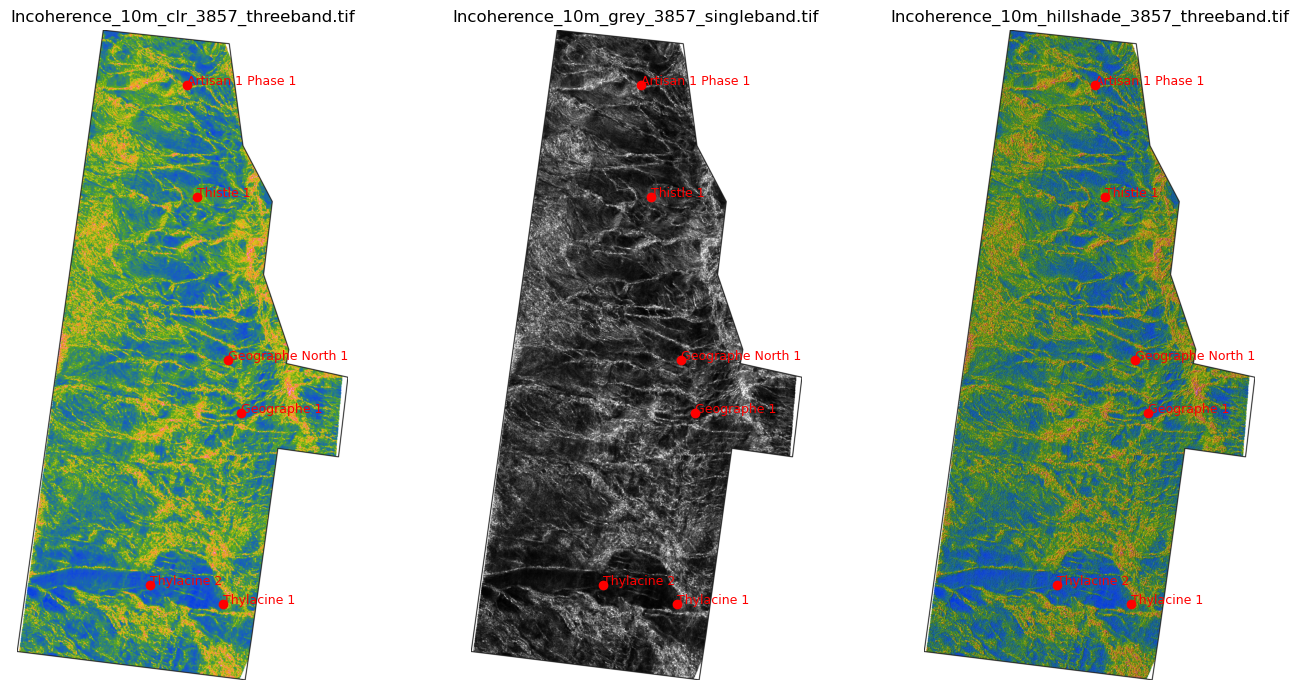

In [94]:
tiff_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.tif')]

# Get the number of tif files
num_files = len(tiff_files)

# Define a list of color maps
color_maps = ['viridis', 'gray', 'inferno']

# Create a subplot for each Tif file
fig, axs = plt.subplots(1, num_files, figsize=(14, 7))

for i, file in enumerate(tiff_files):
    # Read the raster data
    with rasterio.open(file) as src:
        # Read all bands; adjust here if you want specific bands
        raster = src.read()
        
        # Transform the raster for plotting
        raster = raster.transpose(1, 2, 0)
        
        # Check and transform the CRS of points_gdf to match the raster CRS
        if points_gdf.crs != src.crs:
            points_gdf = points_gdf.to_crs(src.crs)

        # Convert points_gdf geometry to raster coordinate system
        points_in_raster_crs = [(src.index(*geom.xy[0], *geom.xy[1])) for geom in points_gdf.geometry]

    # Get a list of well names
    well_names = points_gdf['Well_Name'].tolist()
    
    # Choose color map
    cmap = color_maps[i % len(color_maps)]

    # Plot the data
    ax = axs[i] if num_files > 1 else axs
    ax.imshow(raster, cmap=cmap)

    # Plot the points and label them
    for point, well_name in zip(points_in_raster_crs, well_names):
        ax.plot(point[1], point[0], 'ro')  # 'ro' plots red dots
        ax.text(point[1], point[0], well_name, color='red', fontsize=9)

        ax.set_title(os.path.basename(file))
        ax.axis('off')

plt.tight_layout()
plt.show()

## Pre process the Dataframes

In [ ]:
# Run the preprocessing and dimension reduction
proc_dfs, meta_dfs, umap_obj = preprocess_pipeline(directory_path, 0.95, 100, 0.001, gas, nogas)

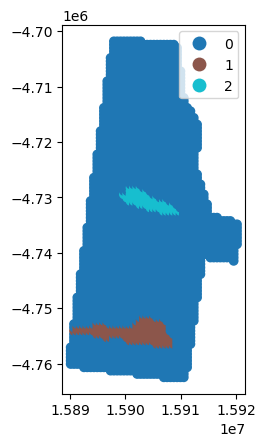

In [96]:
# Plot the classes in plan view to check that they are correct
gdf = gpd.GeoDataFrame(
    meta_dfs['feats_clr'], 
    geometry=gpd.points_from_xy(meta_dfs['feats_clr']['centroid_x'], meta_dfs['feats_clr']['centroid_y'])
)

# Plot using GeoPandas
fig, ax = plt.subplots()
gdf.plot(ax=ax, column='class', legend=True, categorical=True, marker='o', linestyle='')

# Show the plot
plt.show()

## Visualise the UMAP Embeddings

In [129]:
# Visualise and compare the UMAP of each feature set
clr_list = ['#808080', '#800080', '#FF0000']
fig = make_subplots(
    rows=1, cols=3,
    specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}, {'type': 'scatter3d'}]],
    subplot_titles=("Greyscale", "Coloured RGB", "Hillshade RGB")  # This will create titles above each subplot
)

plot1 = Umap_vis(proc_dfs, meta_dfs, 'feats_greyscale', clr_list)
plot2 = Umap_vis(proc_dfs, meta_dfs, 'feats_clr', clr_list)
plot3 = Umap_vis(proc_dfs, meta_dfs, 'feats_hillshade', clr_list)

# Assuming plot1, plot2, plot3 are figure objects
for i, plot in enumerate([plot1, plot2, plot3], start=1):
    for trace in plot.data:
        fig.add_trace(
            go.Scatter3d(
                x=trace.x, y=trace.y, z=trace.z,
                mode=trace.mode, marker=trace.marker
            ),
            row=1, col=i
        )
        
fig.update_layout(height=600, width=1800, title_text="Comparison of UMAP visualisations")

fig.show()

## Cluster the UMAP Embeddings

In [123]:
# Run clustering for each of the feature sets and re-order cluster labels for visualisation purposes
labelled = {}
for key in umap_obj:
    # Run the Louvain clustering
    df = clusters(umap_obj, key, proc_dfs)
    # Re-order the clusters based on UMAP location
    df1 = re_order_clusters(df)
    # append the dataframe to a list
    labelled[key] = df1

[0 1 2 3 4 5 6 7 8 9]
[ 0  1  2  3  4  5  6  7  8  9 10]
[0 1 2 3 4 5 6 7 8 9]


In [124]:
# Reverse the cluster labels from the greyscale features for visualisation purposes
max_class = labelled['feats_greyscale']['reordered_cluster'].max()
labelled['feats_greyscale']['reordered_cluster'] = max_class - labelled['feats_greyscale']['reordered_cluster']

In [125]:
# Visualise and compare the UMAP of each feature set
fig = make_subplots(
    rows=1, cols=3,
    specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}, {'type': 'scatter3d'}]],
    subplot_titles=("Greyscale", "Coloured RGB", "Hillshade RGB")  # This will create titles above each subplot
)

plot1 = Umap_vis_alternative(labelled['feats_greyscale'], 'feats_greyscale')
plot2 = Umap_vis_alternative(labelled['feats_clr'], 'feats_clr')
plot3 = Umap_vis_alternative(labelled['feats_hillshade'], 'feats_hillshade')

# Assuming plot1, plot2, plot3 are figure objects
for i, plot in enumerate([plot1, plot2, plot3], start=1):
    for trace in plot.data:
        fig.add_trace(
            go.Scatter3d(
                x=trace.x, y=trace.y, z=trace.z,
                mode=trace.mode, marker=trace.marker
            ),
            row=1, col=i
        )
        
fig.update_layout(height=600, width=1800, title_text="Comparison of UMAP visualisations")

fig.show()

## Visualise the clusters in plan view

In [126]:
#add the geometry column from each meta data dataframe to the corresponding cluster labels
for key in labelled:
    labelled[key]['geometry'] = meta_dfs[key]['geometry']

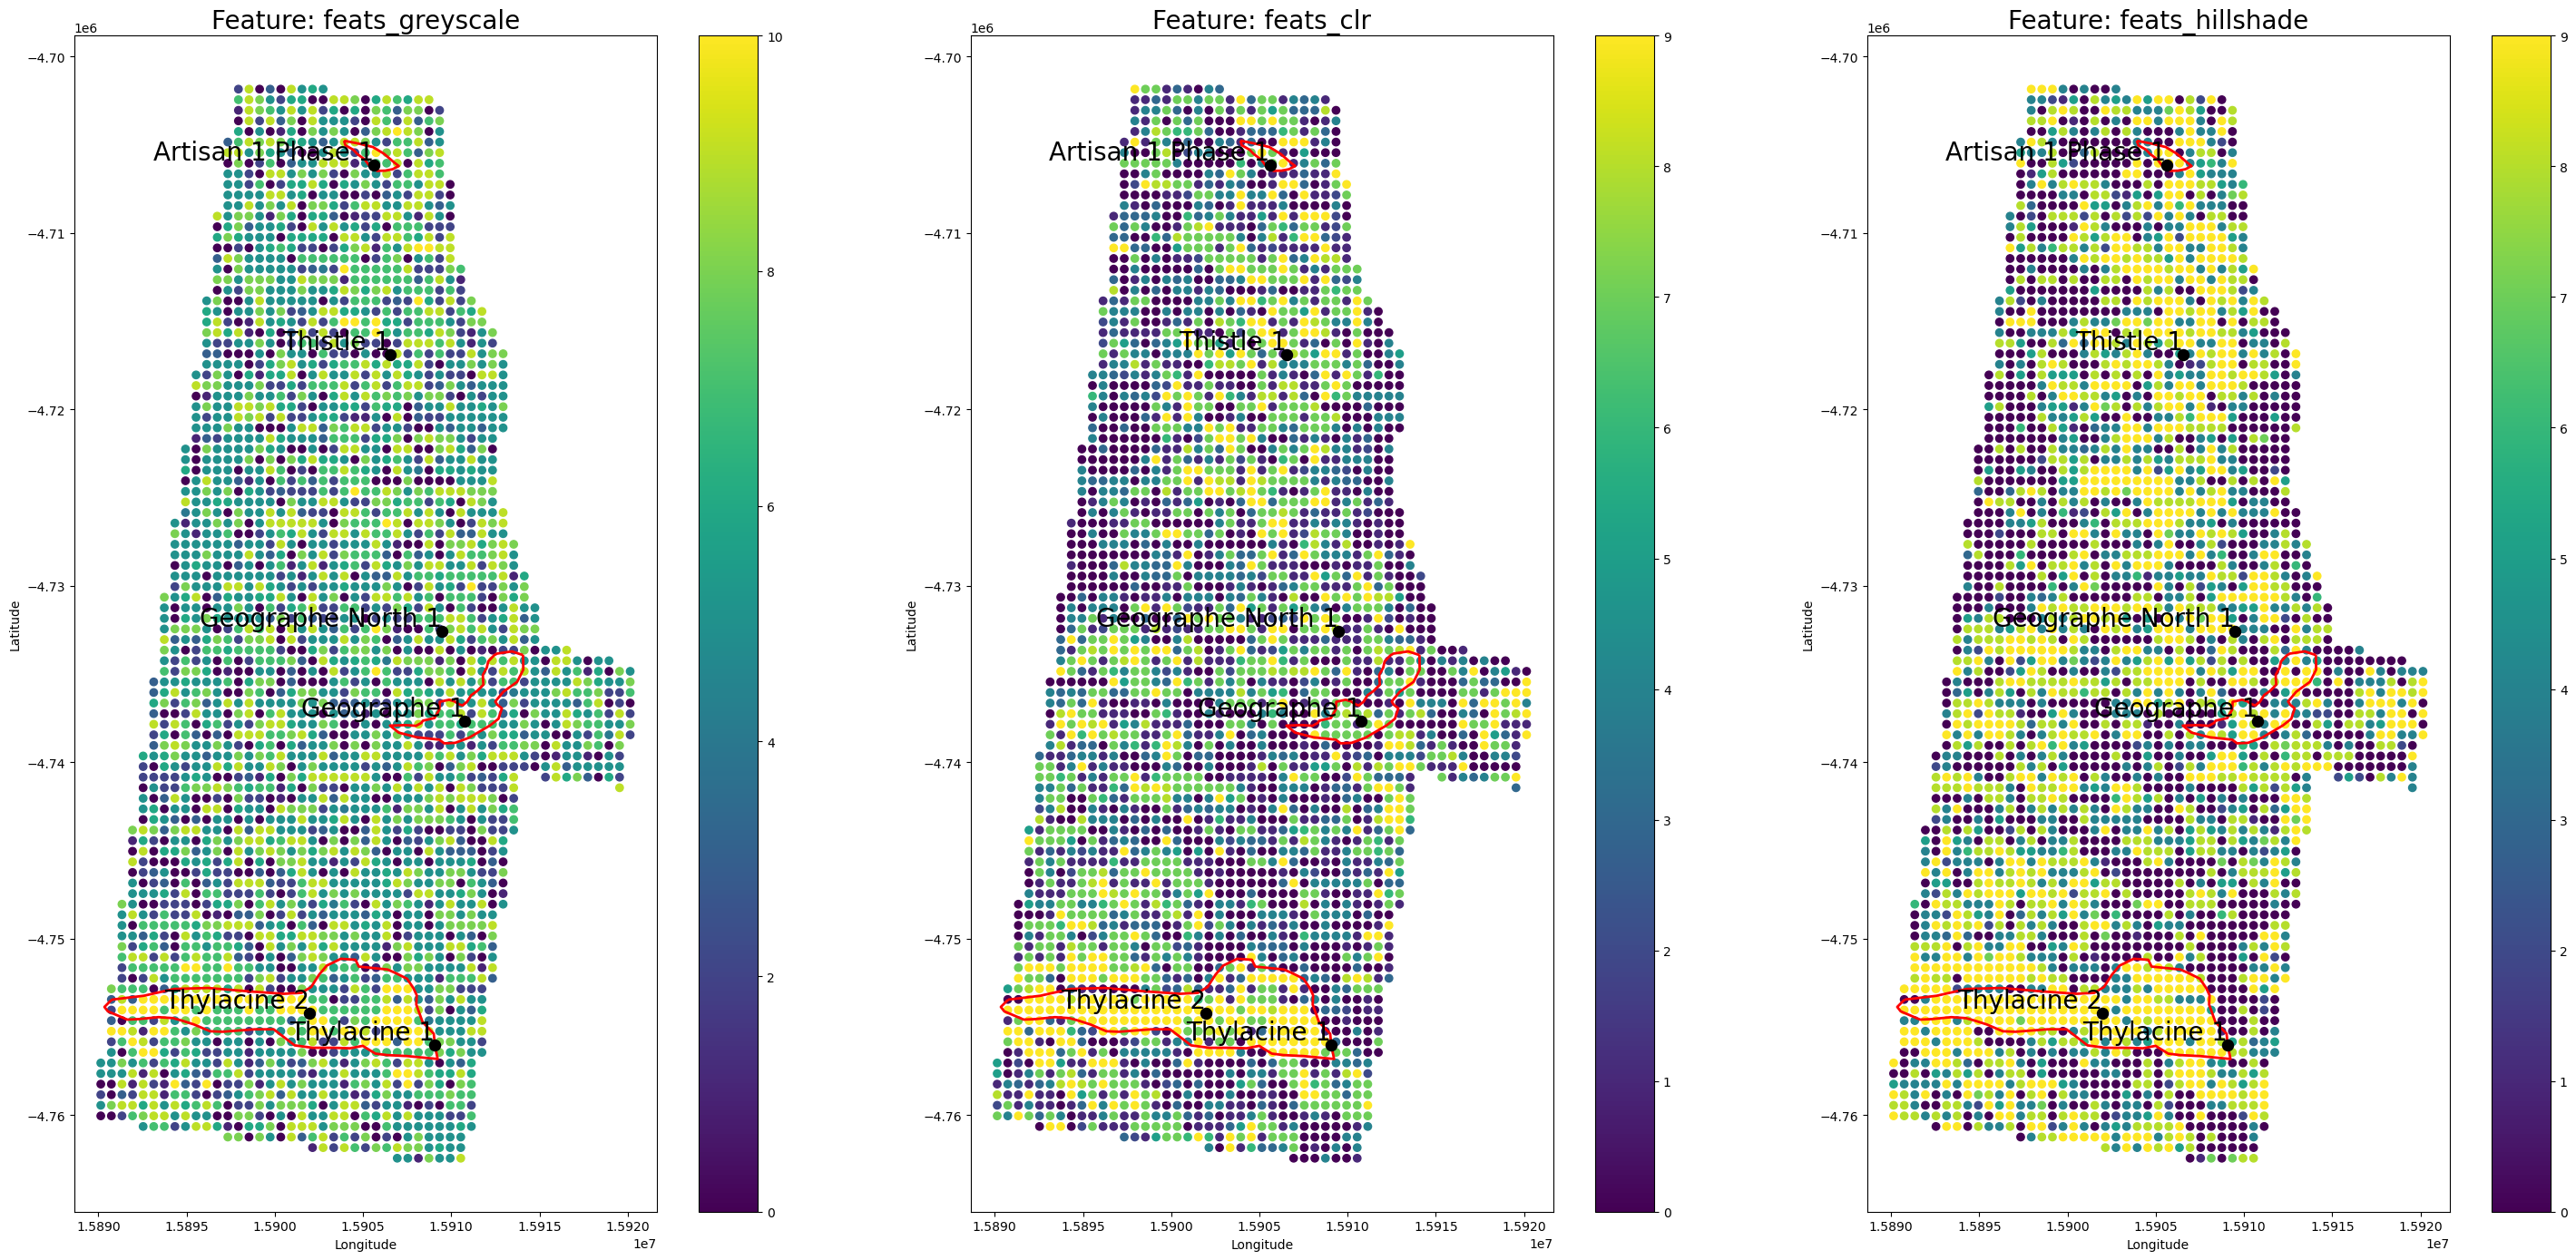

In [128]:
# Visualise the clusters in plan view to compare the results

# Swap the first and second keys in the 'labelled' dictionary
keys = list(labelled.keys())
if len(keys) >= 2:
    keys[0], keys[1] = keys[1], keys[0]

# Specify the number of plots
n_plots = len(labelled)

# Determine the grid size
cols = 3 
rows = -(-n_plots // cols)  # ceiling division to get the number of rows

# Adjust the overall size of the figure
fig, axes = plt.subplots(rows, cols, figsize=(cols * 10, rows * 14))  # Increased size
axes = axes.flatten()

for i, key in enumerate(keys):
    gdf = gpd.GeoDataFrame(labelled[key], geometry='geometry')
    # Plotting in the i-th subplot
    gdf.plot(ax=axes[i], column='reordered_cluster', legend=True)
    
    # Plot the 'gas' polygons on the same axis
    gas.plot(ax=axes[i], color='none', edgecolor='red', linewidth=2)
    
    # Plot the wells from the GeoPackage
    points_gdf.plot(ax=axes[i], marker='o', color='black', markersize=75)
    
    # Label the points with the well name
    for idx, row in points_gdf.iterrows():
        axes[i].text(row.geometry.x, row.geometry.y, s=row['Well_Name'], fontsize=20, ha='right', va='bottom')

    # Customizations
    axes[i].set_title(f'Feature: {key}', fontsize=20)
    axes[i].set_xlabel('Longitude')
    axes[i].set_ylabel('Latitude')

# If there are any remaining empty subplots, turn them off
for j in range(i + 1, rows * cols):
    axes[j].axis('off')

plt.tight_layout() 
plt.show()